<a href="https://colab.research.google.com/github/YoonHyeJu/project1/blob/master/cat_dog_imgClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
_URL = 'http://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [9]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size, 
                                                           directory= train_dir,
                                                           shuffle = True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [13]:
sample_training_images, _ = next(train_data_gen)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip (images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

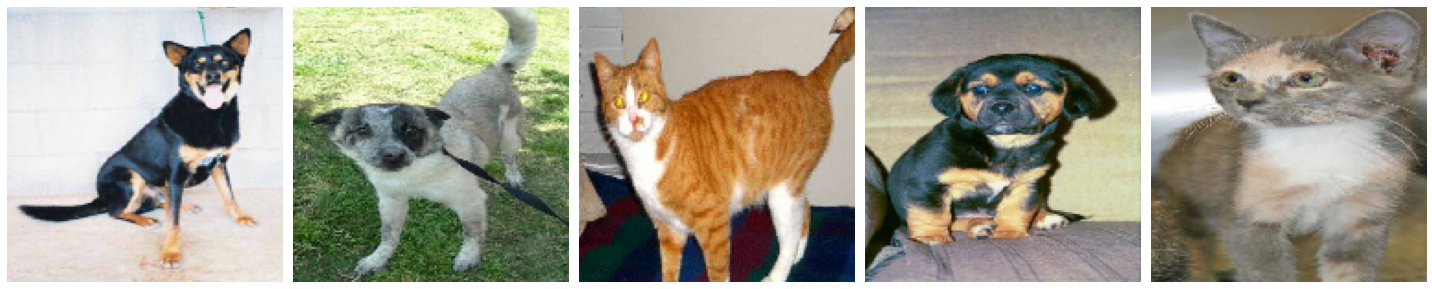

In [15]:
plotImages(sample_training_images[:5])

In [18]:
model = Sequential([
                    Conv2D(16, 3, padding='same', activation='relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
                    MaxPooling2D(),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1)
])
### Conv2D ###
# 16 <- convolution filter의 수
# padding - same: 출력 이미지 사이즈가 입력 이미지 사이즈와 동일
#         - valid: 유효한 영역만 출력. 출력 이미지 사이즈 < 입력 사이즈
# input_shape: 샘플 수를 제외한 입력 형태를 정의. 첫 레이어에서만 정의하면 됨.
#              (행, 열, 채널 수)로 정의. 채널은 흑백인 경우 1, 컬러인 경우 3 
# activation - linear: 디폴트? 입력 뉴런과 가중치로 계산된 결과값이 그대로 출력.
#            - 'relu: hidden layer에 주로 사용
#            - sigmoid: 이진 분류 문제에서 출력층에 주로 쓰임
#            - softmax: 다중 클래스 분류 문제에서 출력층에 주로 쓰임

### MaxPooling ###
# convolution layer의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만듦.

### Flatten ###
# CNN에서 convolution layer나 MaxPooling layer를 반복적으로 거치면 주요 특징만 추출되고,
# 추출된 주요 특징은 전결합층에 전달되어 학습된다.
# convolution layer나 MaxPooling layer는 주로 2차원 자료를 다루는데
# 전결합층에 전달하기 위해선 1차원 자료로 바꿔줘야 하는데 이 때 Flatten이 사용된다.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
             metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0

In [23]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 9s 577ms/step - loss: 0.6560 - accuracy: 0.5630 - val_loss: 0.6437 - val_accuracy: 0.6808
Epoch 2/15
15/15 [==============================] - 9s 574ms/step - loss: 0.6034 - accuracy: 0.6496 - val_loss: 0.5878 - val_accuracy: 0.6931
Epoch 3/15
15/15 [==============================] - 9s 568ms/step - loss: 0.5657 - accuracy: 0.6976 - val_loss: 0.5688 - val_accuracy: 0.6786
Epoch 4/15
15/15 [==============================] - 9s 569ms/step - loss: 0.5259 - accuracy: 0.7203 - val_loss: 0.5511 - val_accuracy: 0.7065
Epoch 5/15
15/15 [==============================] - 8s 566ms/step - loss: 0.4810 - accuracy: 0.7623 - val_loss: 0.5419 - val_accuracy: 0.7087
Epoch 6/15
15/15 [==============================] - 9s 569ms/step - loss: 0.4464 - accuracy: 0.7847 - val_loss: 0.5318 - val_accuracy: 0.7221
Epoch 7/15
15/15 [==============================] - 9s 569ms/step - loss: 0.3972 - accuracy: 0.8162 - val_loss: 0.5349 - val_accuracy: 0.7232
Epoch 

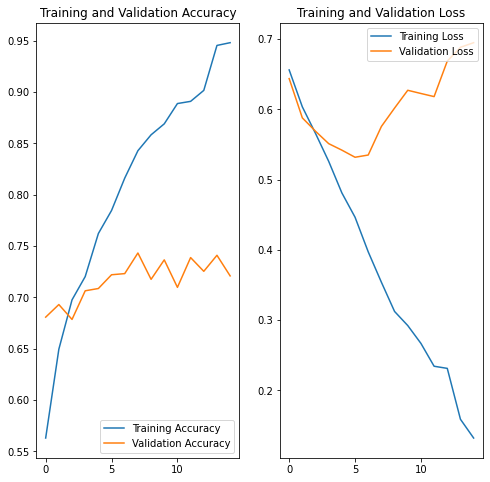

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [27]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory = train_dir, 
                                               shuffle = True,
                                               target_size = (IMG_HEIGHT, IMG_WIDTH))


Found 2000 images belonging to 2 classes.


In [28]:
agumented_images = [train_data_gen[0][0][0] for i in range(5)]

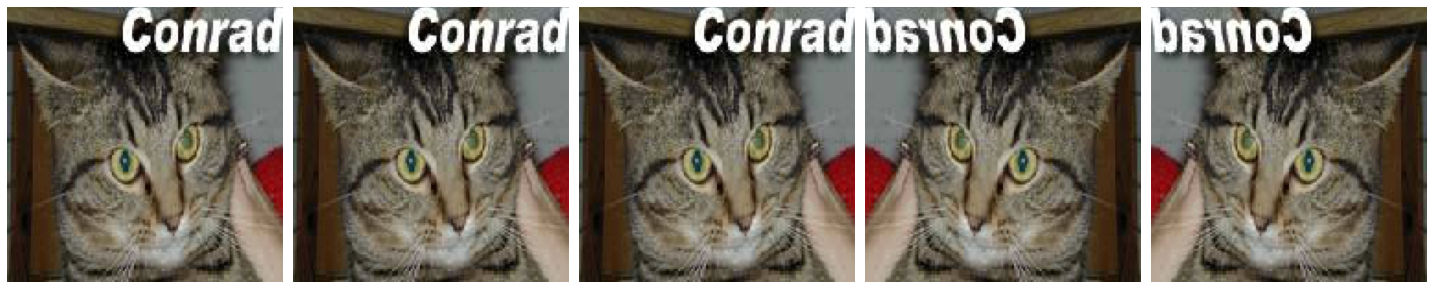

In [29]:
plotImages(agumented_images)

In [31]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [32]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (IMG_HEIGHT, IMG_WIDTH))

agumented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


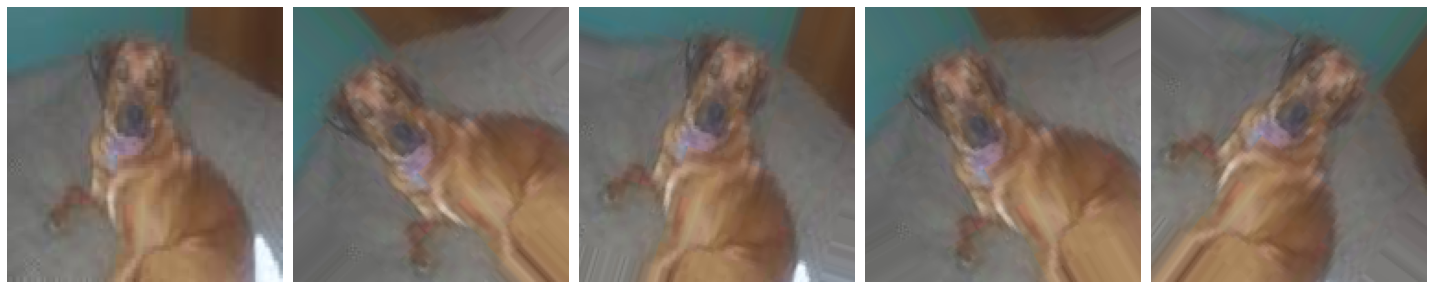

In [33]:
plotImages(agumented_images)

In [34]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [35]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
agumented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


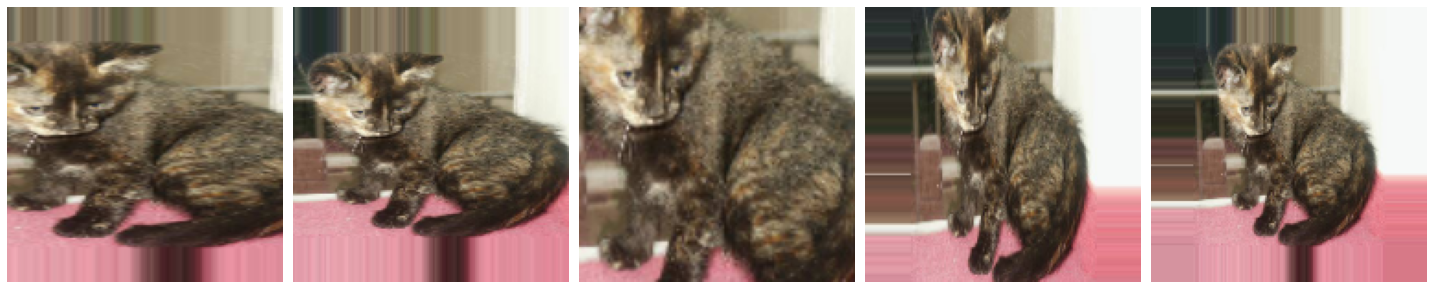

In [36]:
plotImages(agumented_images)

In [37]:
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip = True,
    zoom_range=0.5
)

In [38]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary')

Found 2000 images belonging to 2 classes.


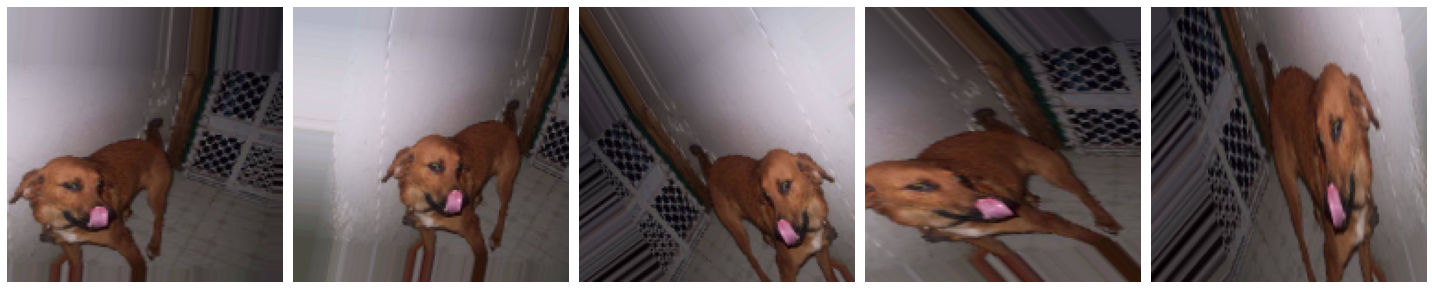

In [39]:
agumented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(agumented_images)

In [40]:
image_gen_val = ImageDataGenerator(rescale = 1./255)

In [41]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory = validation_dir,
                                                 target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [42]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [43]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)       

In [44]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 17s 1s/step - loss: 1.0806 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4978
Epoch 2/15
15/15 [==============================] - 17s 1s/step - loss: 0.6915 - accuracy: 0.5107 - val_loss: 0.6827 - val_accuracy: 0.4978
Epoch 3/15
15/15 [==============================] - 17s 1s/step - loss: 0.6876 - accuracy: 0.5198 - val_loss: 0.6712 - val_accuracy: 0.5658
Epoch 4/15
15/15 [==============================] - 17s 1s/step - loss: 0.6784 - accuracy: 0.5449 - val_loss: 0.6694 - val_accuracy: 0.5536
Epoch 5/15
15/15 [==============================] - 17s 1s/step - loss: 0.6847 - accuracy: 0.5267 - val_loss: 0.6629 - val_accuracy: 0.5580
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 0.6605 - accuracy: 0.5743 - val_loss: 0.6383 - val_accuracy: 0.6027
Epoch 7/15
15/15 [==============================] - 17s 1s/step - loss: 0.6527 - accuracy: 0.5726 - val_loss: 0.6368 - val_accuracy: 0.6150
Epoch 8/15
15/15 [==

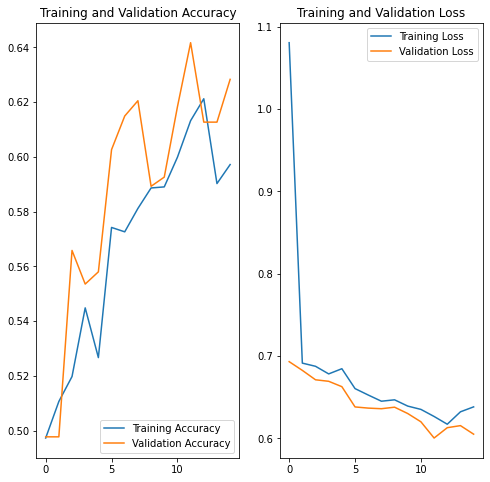

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()